<a href="https://colab.research.google.com/github/tvpian/NERF_Series/blob/main/NERF_Series_02_3D_Reconstruction_with_modules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import imageio

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [5]:
!unzip -q fox.zip

## Camera Dataset

In [6]:
def get_rays(datapath, mode = 'train'):
    pose_file_names = os.listdir(datapath + f'/{mode}/pose')
    intrinsic_file_names = os.listdir(datapath + f'/{mode}/intrinsics') # Paramters related to the camera
    img_file_names = [f for f in os.listdir(datapath + '/imgs') if mode in f]
    assert len(pose_file_names) == len(intrinsic_file_names)
    assert len(pose_file_names) == len(img_file_names)


    # Read
    N = len(pose_file_names)  # Number of images
    poses = np.zeros((N, 4, 4))  # 4x4 matrix containing the extrinsic parameters
    intrinsics = np.zeros((N, 4, 4)) # 4x4 matrix containing the intrinsic parameters
    images = []


    for i in range(N):
        pose = np.loadtxt(datapath + f'/{mode}/pose/' + pose_file_names[i]).reshape(4, 4)
        # print(pose.shape)
        intrinsic = np.loadtxt(datapath + f'/{mode}/intrinsics/' + intrinsic_file_names[i]).reshape(4, 4)
        # print(intrinsic.shape)
        img = imageio.imread(datapath + '/imgs/' + img_file_names[i])/255.0
        # print(img.shape)
        images.append(img[None])
        poses[i] = pose
        intrinsics[i] = intrinsic
    images = np.concatenate(images, axis=0)

    H = images.shape[1]
    W = images.shape[2]

    if images.shape[3] == 4: #RGBA -> RGB
        images = images[:, :, :, :3] * images[:, :, :, -1:] + (1 - images[:, :, :, -1:]) # White background has 0 opacity hence subtracting from 1 makes back to white again

    plt.imshow(images[0]) # Sample plot
    plt.show()
    # print(images.shape

    rays_o = np.zeros((N, H * W, 3))
    rays_d = np.zeros((N, H * W, 3))
    target_px_values = images.reshape((N, H*W, 3))

    for i in range(N):
       u = np.linspace(0, W - 1, W)
       v = np.linspace(0, H - 1, H)
       u, v = np.meshgrid(u, v)
       c2w = poses[i]
       f = intrinsics[i, 0, 0]
       dirs = np.stack(((u - W/2),
                        -(v - H/2),
                        -np.ones_like(u) * f), axis = -1)
       dirs = (c2w[:3, :3] @ dirs[..., None]).squeeze(-1)
       dirs = dirs / np.linalg.norm(dirs, axis=-1, keepdims=True)
       rays_d[i] = dirs.reshape(-1, 3)
       rays_o[i] = c2w[:3, 3]


    return rays_d, rays_o, target_px_values





<ipython-input-6-7ba6015ed398>:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(datapath + '/imgs/' + img_file_names[i])/255.0


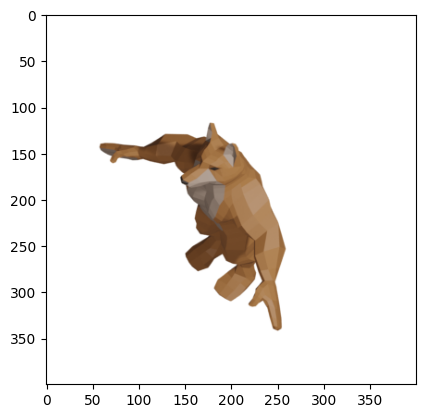

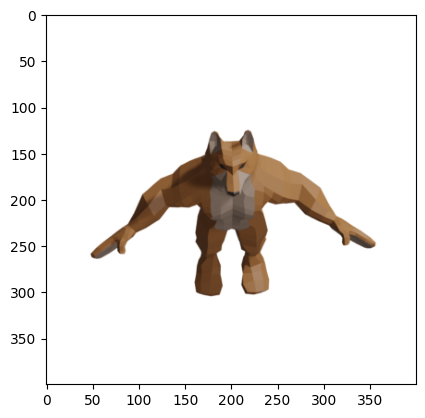

In [8]:
rays_o[0]

array([[-1.438537  , -7.90747166,  5.94999981],
       [-1.438537  , -7.90747166,  5.94999981],
       [-1.438537  , -7.90747166,  5.94999981],
       ...,
       [-1.438537  , -7.90747166,  5.94999981],
       [-1.438537  , -7.90747166,  5.94999981],
       [-1.438537  , -7.90747166,  5.94999981]])

In [12]:
rays_o[-1]

array([[ 3.26013827, -5.68937588,  7.55000019],
       [ 3.26013827, -5.68937588,  7.55000019],
       [ 3.26013827, -5.68937588,  7.55000019],
       ...,
       [ 3.26013827, -5.68937588,  7.55000019],
       [ 3.26013827, -5.68937588,  7.55000019],
       [ 3.26013827, -5.68937588,  7.55000019]])

<ipython-input-6-7ba6015ed398>:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(datapath + '/imgs/' + img_file_names[i])/255.0


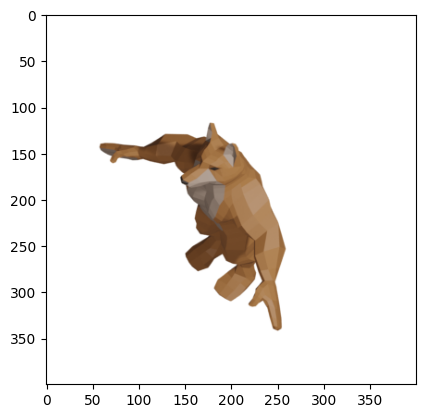

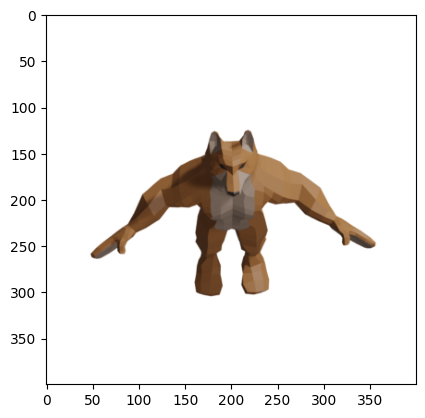

In [9]:
batch_size = 1024
rays_d, rays_o, target_px_values = get_rays('/content/fox', mode = 'train')
dataloader = DataLoader(torch.cat((torch.from_numpy(rays_o),
                                   torch.from_numpy(rays_d),
                                   torch.from_numpy(target_px_values)), dim=1), batch_size=batch_size, shuffle=True)

test_rays_o, test_rays_d, test_target_px_values = get_rays('/content/fox', mode = 'test')

In [11]:
test_target_px_values.shape

(10, 160000, 3)

## Rendering

## Model

## Training